# Классификация рукоисных цифр с помощью полносвязной нейронной сети(FNN)

In [1]:
#Импортируем библиотеки
import os
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import random
import numpy as np
import pandas as pd
import tqdm

# Устанавливаем random seed'ы для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
# Скачиваем датасет MNIST (содержит рукописные цифры от 0 до 9 )
sample = pd.read_csv('mnist_sample_submission.csv')
train_df = pd.read_csv('mnist_train.csv')
test_df = pd.read_csv('mnist_test.csv')

print(f"Number of training samples: {len(train_df)}")
print("Any missing data? ", train_df.isnull().values.any())
print(f"Dataframe shape: {train_df.shape}")

Number of training samples: 42000
Any missing data?  False
Dataframe shape: (42000, 785)


In [3]:
X, y = train_df.drop(labels = 'label', axis=1), train_df['label']

In [4]:
# Разделяем датасет на тренировочную часть и на валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# Преобразуем DataFrame в Tensor
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [6]:
# Посмотрим тип наших данных
X_train.dtype, y_train.dtype

(torch.int64, torch.int64)

In [7]:
# Преобразуем данные в дробные числа
X_train = X_train.float()
X_test = X_test.float()

In [8]:
# Посмотрим на размерность датасета. Первое число - количество изображений, 2-е количество пикселей(28х28)
X_train.shape, X_test.shape

(torch.Size([33600, 784]), torch.Size([8400, 784]))

In [9]:
y_train.shape, y_test.shape

(torch.Size([33600]), torch.Size([8400]))

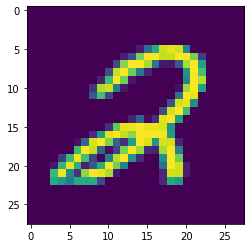

tensor(2)


In [10]:
# Посмотрим как выглядят числа с помощью библиотеки matplotlib
import matplotlib.pyplot as plt
plt.imshow(X_train.reshape(-1, 28, 28)[4,:,:])
plt.show()
print(y_train[4])


In [11]:
# Создаем нейросетку
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [12]:
# Переведем вычисления на видеокарту
torch.cuda.is_available()  # посмотрим, доступна ли видеокарта

True

In [13]:
# Консольная укоманда для просмотра информации о видеокарте
!nvidia-smi

Fri Jan 22 18:27:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.79       Driver Version: 460.79       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 107... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8    12W / 180W |   2002MiB /  8192MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)  # Переложим нейросеть на видеокарту
list(mnist_net.parameters())  # Убедимся что параметры вычисляются на видеокарты

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -

In [15]:
# Создаем лосс функцию - кроссэнтропия (софтмакс уже встроен в нее)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3) # Выбор метода оптимизации loss функции, в данном случае Adam

In [16]:
# Реализуем побатчевый градиентный спуск
batch_size = 100 # Размер батча 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.8986)
tensor(0.9061)
tensor(0.9117)
tensor(0.9157)
tensor(0.9165)
tensor(0.9177)
tensor(0.9200)
tensor(0.9182)
tensor(0.9221)
tensor(0.9175)
tensor(0.9258)
tensor(0.9161)
tensor(0.9224)
tensor(0.9246)
tensor(0.9230)
tensor(0.9256)
tensor(0.9214)
tensor(0.9302)
tensor(0.9238)
tensor(0.9300)
tensor(0.9326)
tensor(0.9304)
tensor(0.9283)
tensor(0.9326)
tensor(0.9354)
tensor(0.9385)
tensor(0.9355)
tensor(0.9383)
tensor(0.9357)
tensor(0.9358)
tensor(0.9327)
tensor(0.9340)
tensor(0.9375)
tensor(0.9396)
tensor(0.9377)
tensor(0.9336)
tensor(0.9388)
tensor(0.9425)
tensor(0.9420)
tensor(0.9419)
tensor(0.9408)
tensor(0.9388)
tensor(0.9425)
tensor(0.9389)
tensor(0.9361)
tensor(0.9356)
tensor(0.9427)
tensor(0.9423)
tensor(0.9402)
tensor(0.9390)
tensor(0.9411)
tensor(0.9419)
tensor(0.9417)
tensor(0.9458)
tensor(0.9418)
tensor(0.9406)
tensor(0.9417)
tensor(0.9380)
tensor(0.9394)
tensor(0.9389)
tensor(0.9471)
tensor(0.9468)
tensor(0.9443)
tensor(0.9469)
tensor(0.9439)
tensor(0.9439)
tensor(0.9

KeyboardInterrupt: 

In [17]:
# Создаем файл посылки для kaggle:
test_df = torch.tensor(test_df.values)
test_df = test_df.float()
preds = mnist_net.forward(test_df.to(device))
preds = preds.argmax(dim=1).cpu().numpy()
sample['Label'] = pd.DataFrame(preds)
sample.to_csv('submission_mnist.csv',index=False)